In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import geometry_mask

# Visualization
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 1. Import data
## 1.1 Climatic data

# Chelsa Data
The image is of size (20880, 43200, 3). Axis 2 is a repetition of the value, hence we get all the information we need with a (20880, 43200) array.

From the size of the image, the coordinates system used is:

- Projection: Geographic (latitude/longitude)
- Datum: WGS84 (World Geodetic System 1984)

The resolution is 30 arc seconds. When downsampling with a kernel size of 10, the resolution is ~5 arc minutes. This represents ~9.26 kilometers at the equator (should be enough for our data analysis).


In [ ]:
''' functions.py '''
def load_geotiff(file_name):
    ''' Load .tiff files containing climatic data
    
    Input:
        file_name: str
            Path to .tiff file

    Output:
        data: np.array
            2d downscaled array containing climatic values in each pixel
    
    '''
    
    _ = np.newaxis
    # downsampling_layer = torch.nn.MaxPool2d(kernel_size=10, stride=10)
    downsampling_layer = torch.nn.AvgPool2d(kernel_size=10, stride=10)
    # downsampling_layer = torch.nn.Conv2d(1, 1, kernel_size=10, stride=10)

    with rasterio.open(file_name) as src:
        array = src.read(1, out_dtype=np.float32)
        data = downsampling_layer(torch.tensor(array[_,_,:,:], dtype=torch.float32)).detach().numpy()

    return data[0,0]

In [ ]:
# Import precipitation and temperature data
# Approximate runtime: 10 minutes
DATA_FOLDER = "../data/"
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

tmean_data = np.zeros((12, 2088, 4320))
prec_data = np.zeros((12, 2088, 4320))
tmin_data = np.zeros((12, 2088, 4320))
tmax_data = np.zeros((12, 2088, 4320))

for i, month in enumerate(months):

    tmean_file = load_geotiff(os.path.join(DATA_FOLDER, 'temp', f"CHELSA_tmean_2013_{month}_V1.2.1.tif"))
    prec_file = load_geotiff(os.path.join(DATA_FOLDER, 'prec', f"CHELSA_prec_2013_{month}_V1.2.1.tif"))
    tmin_file = load_geotiff(os.path.join(DATA_FOLDER, 'min', f"CHELSA_tmin_2013_{month}_V1.2.1.tif"))
    tmax_file = load_geotiff(os.path.join(DATA_FOLDER, 'max', f"CHELSA_tmax_2013_{month}_V1.2.1.tif"))

    tmean_data[i] = tmean_file
    prec_data[i] = prec_file
    tmin_data[i] = tmin_file
    tmax_data[i] = tmax_file

    # print(f"Processed month {month}\nmean temperature: {np.mean(tmean_data[i]):.2f}°C\nmean precipitation: {np.mean(prec_data[i]):.2f} mm\nmin temperature: {np.mean(tmin_data[i]):.2f}°C\nmax temperature: {np.mean(tmax_data[i]):.2f}°C\n")

# Convert temperature data to [°C]
tmean_data =  np.multiply(tmean_data, 1/10) - 273.15
tmin_data =  np.multiply(tmin_data, 1/10) - 273.15
tmax_data =  np.multiply(tmax_data, 1/10) - 273.15

Processed month 01
mean temperature: 2784.50°C
mean precipitation: 46118.37 mm
min temperature: 2766.56°C
max temperature: 2802.44°C

Processed month 02
mean temperature: 2774.20°C
mean precipitation: 46117.05 mm
min temperature: 2754.92°C
max temperature: 2793.48°C

Processed month 03
mean temperature: 2775.39°C
mean precipitation: 46117.73 mm
min temperature: 2754.51°C
max temperature: 2796.27°C

Processed month 04
mean temperature: 2784.21°C
mean precipitation: 46117.36 mm
min temperature: 2763.32°C
max temperature: 2805.09°C

Processed month 05
mean temperature: 2797.08°C
mean precipitation: 46121.33 mm
min temperature: 2776.27°C
max temperature: 2817.88°C

Processed month 06
mean temperature: 2813.91°C
mean precipitation: 46120.35 mm
min temperature: 2793.59°C
max temperature: 2834.24°C

Processed month 07
mean temperature: 2812.36°C
mean precipitation: 46123.32 mm
min temperature: 2792.66°C
max temperature: 2832.07°C

Processed month 08
mean temperature: 2814.10°C
mean precipitat

## 1.2 Geographic rasters (maps of the world and of the us)

# Natural Earth datasets have the following properties:

- has a 'geometry' column containg data of type <class 'shapely.geometry.multipolygon.MultiPolygon'>
- Datum: WGS84 but given in unit of degrees

# We download two datasets:

- *ne_110m_admin_0_countries.shp* : contains geometries of every country in the world
- *ne_50m_admin_1_states_provinces.shp* : containes geometries of regions of some big countries. We are interested in the USA.

In [18]:
# Import world map (with region delimitation) and select desired columns
world_all = gpd.read_file('../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
# world_all = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world_all.loc[:, ['ADMIN', 'geometry']]

# Create Dataframe containing USA states only
# We remove the states of Hawaii and Alaska for visualization purpose and because we don't need them in our analysis
states_gdf = gpd.read_file('../data/ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp')
states_gdf_reduced = states_gdf.loc[:, ['admin', 'name', 'geometry']]
us = states_gdf_reduced[states_gdf_reduced['admin'] == 'United States of America']
us = us[us['name'] != 'Alaska']
us = us[us['name'] != 'Hawaii']

In [33]:
belgium = world[world["ADMIN"] == "Belgium"]

world["ADMIN"].to_csv('world_admin.csv')

In [43]:
belgium["geometry"].values

<GeometryArray>
[<POLYGON ((6.16 50.8, 6.04 50.1, 5.78 50.1, 5.67 49.5, 4.8 50, 4.29 49.9, 3....>]
Length: 1, dtype: geometry

# 2. Seasonal variation of mean temperature in Belgium

In [ ]:
''' funtions.py '''
def animation_belgium(world, clim_data, variable):
    ''' Create an animation of yearly climatic variable in Belgium
    
    Input:
        world: gpd.GeoDataFrame
            Geometries of all countries, previously downloaded from naturalearth dataset

        clim_data: np.array of size (12, 2088, 4320)
            Climatic variable data for 12 months acrosse the world
        
        variable: str
            Specifies the unit of the axis

    Output:
        anim: .gif
            animation in saved as a .gif format

    '''

    belgium = world[world["ADMIN"] == "Belgium"]

    pixel_size = 360 / clim_data[0].shape[1]
    transform = from_origin(-180, 90, pixel_size, pixel_size)

    mask = geometry_mask(
            geometries=belgium["geometry"].values,
            out_shape=clim_data[0].shape,
            transform=transform,
            invert=True  # True where the geometry is located
        )
    
    # Generate animation

    if (variable == "tmean") or(variable == "tmin") or (variable == "tmax"):
        label = "Temperature [°C]"
    elif variable == "prec":
        label = "Precipitation [mm]"
    else:
        label = ""

    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = 'seismic'

    vmin = 0
    vmax = 30
    norm = Normalize(vmin=vmin, vmax=vmax)

    # add legend
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label(f"{label}")  # Label the color bar with the variable name
    

    def update(frame):
        months = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
        ax.clear()  # Clear previous plot

        masked_data = np.where(mask, clim_data[frame], np.nan)

        ax.imshow(masked_data, cmap=cmap, vmin=vmin , vmax=vmax)  # Initialize with the first frame
        ax.set_title(f"{months[frame]}")
        ax.set_axis_off()
        ax.set_xlim(2180,2240)
        ax.set_ylim(450,500)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(12), repeat=True)

    # Save the animation as a GIF file
    anim.save(f"belgium_{variable}.gif", writer="pillow", fps=3)


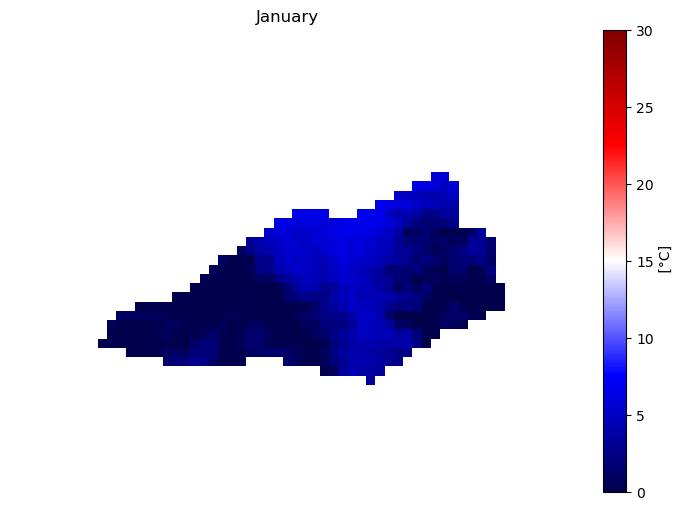

In [199]:
animation_belgium(world, tmean_data, 'temperature')

# 3. Weather differences across states in the USA

In [ ]:
''' functions.py '''
def interpolate_temp(data, map_gdf):
    """
    Interpolate the average temperature per country.

    Input:
        data: np.array of shape (2088, 4320)
            Climatic data
        map_gdf: gpd.GeoDataFrame
            Contains geometries of regions or countries

    Output:
        mean_values: list
            interpolated mean climatic value per region of map_gdf
    """
    # Define pixel size and transformation for WGS84
    pixel_size = 360 / data.shape[1]  # Calculate pixel size dynamically based on array dimensions
    transform = from_origin(-180, 90, pixel_size, pixel_size)

    mean_values = []

    # Loop through each country and compute the mean temperature
    for _, country in map_gdf.iterrows():
        # Convert country geometry to GeoJSON format
        geom = [country['geometry'].__geo_interface__]

        # Create a mask for the current country geometry
        mask = geometry_mask(
            geometries=geom,
            out_shape=data.shape,
            transform=transform,
            invert=True  # True where the geometry is located
        )

        # Apply mask to the temperature data
        masked_data = np.where(mask, data, np.nan)

        # Calculate the mean temperature for the country, ignoring NaNs
        mean = np.nanmean(masked_data)
        mean_values.append(mean)

    return mean_values

In [ ]:
''' functions.py '''
def generate_usgdfs(us, tmean_data, prec_data):
    ''' 
    Interpolates climatic data for USA states, for each month of the year and store monthly gdf in a list
    
    Input:
        us: gpd.GeoDataFrame
            Geometries of USA states, previously downloaded from naturalearth dataset

        tmean_data: np.array of size (12, 2088, 4320)
            Temperature data for 12 months acrosse the world

        prec_data: np.array of size (12, 2088, 4320)
            Precipitation data for 12 months acrosse the world
    
    '''

    t_stats = np.zeros((12, 49))
    p_stats = np.zeros((12, 49))

    # Append a gdf per month in the list us_gdfs
    # Standardize the temperature and precipitation data
    for i in range(12):
        t_stat = interpolate_temp(tmean_data[i,:,:], us)
        p_stat = interpolate_temp(prec_data[i,:,:], us)
        t_stats[i] = t_stat #(t_stat - us_mean_temp) / us_std_temp
        p_stats[i] = p_stat #(p_stat - us_mean_prec) / us_std_prec

    # Normalize temperature and precipitation data
    av_tmean_states = np.mean(t_stats)
    std_tmean_states = np.std(t_stats)
    av_prec_states = np.mean(p_stats)
    std_prec_states = np.std(p_stats)

    # create list of geodataframe with interpolated climatic data (one per month)
    us_gdfs = []

    for j in range(12):
        gdf = us.copy()
        gdf['tmean'] = (t_stats[j] - av_tmean_states) / std_tmean_states
        gdf['prec'] = (p_stats[j] - av_prec_states) / std_prec_states
        us_gdfs.append(gdf)

    return us_gdfs, t_stats, p_stats


def plot_usa(us_gdfs, variable):
    ''' Plots a map of a given climatic variable in the USA.
    
    Input: 
        us_gdfs: list of gpd.GeoDataFrame
            Contains monthly climatic data and geometries of USA states
        
        variable: str
            Specifies the unit of the axis
            
    '''
    
    months = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    
    if variable == 'tmean':
        name = 'mean temperature'
    elif variable == 'prec':
        name = 'precipitation'
    else:
        print("Please enter valid 'variable' name")
    
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs = axs.ravel()

    all = [gdf[variable].values for gdf in us_gdfs]
    vmin = min([value.min() for value in all])
    vmax = max([value.max() for value in all])

    # normalize all data!!
    for i, ax in enumerate(axs):
        # im = axs[i].imshow(temp_data[i], cmap='hot')  # Initialize with the first frame
        # cbar = plt.colorbar(im, ax=axs[i])
        # cbar.set_label('Color Intensity')  # Optionally, add a label to the colorbar


        us_gdfs[i].plot(column=variable, ax=ax, legend=True, cmap='seismic', vmin=vmin, vmax=vmax,
                        legend_kwds={'label': f"Average {name}",
                                    'orientation': 'horizontal'},
                        missing_kwds={'color': 'lightgrey'})
        ax.set_title(f'{months[i]}')
        ax.axis('off')  # Turn off the axis 

    fig.suptitle(f"Monthly {name} in the United States")
    plt.tight_layout()
    plt.show()

In [75]:
us_gdfs, t_stats, p_stats = generate_usgdfs(us, tmean_data, prec_data)

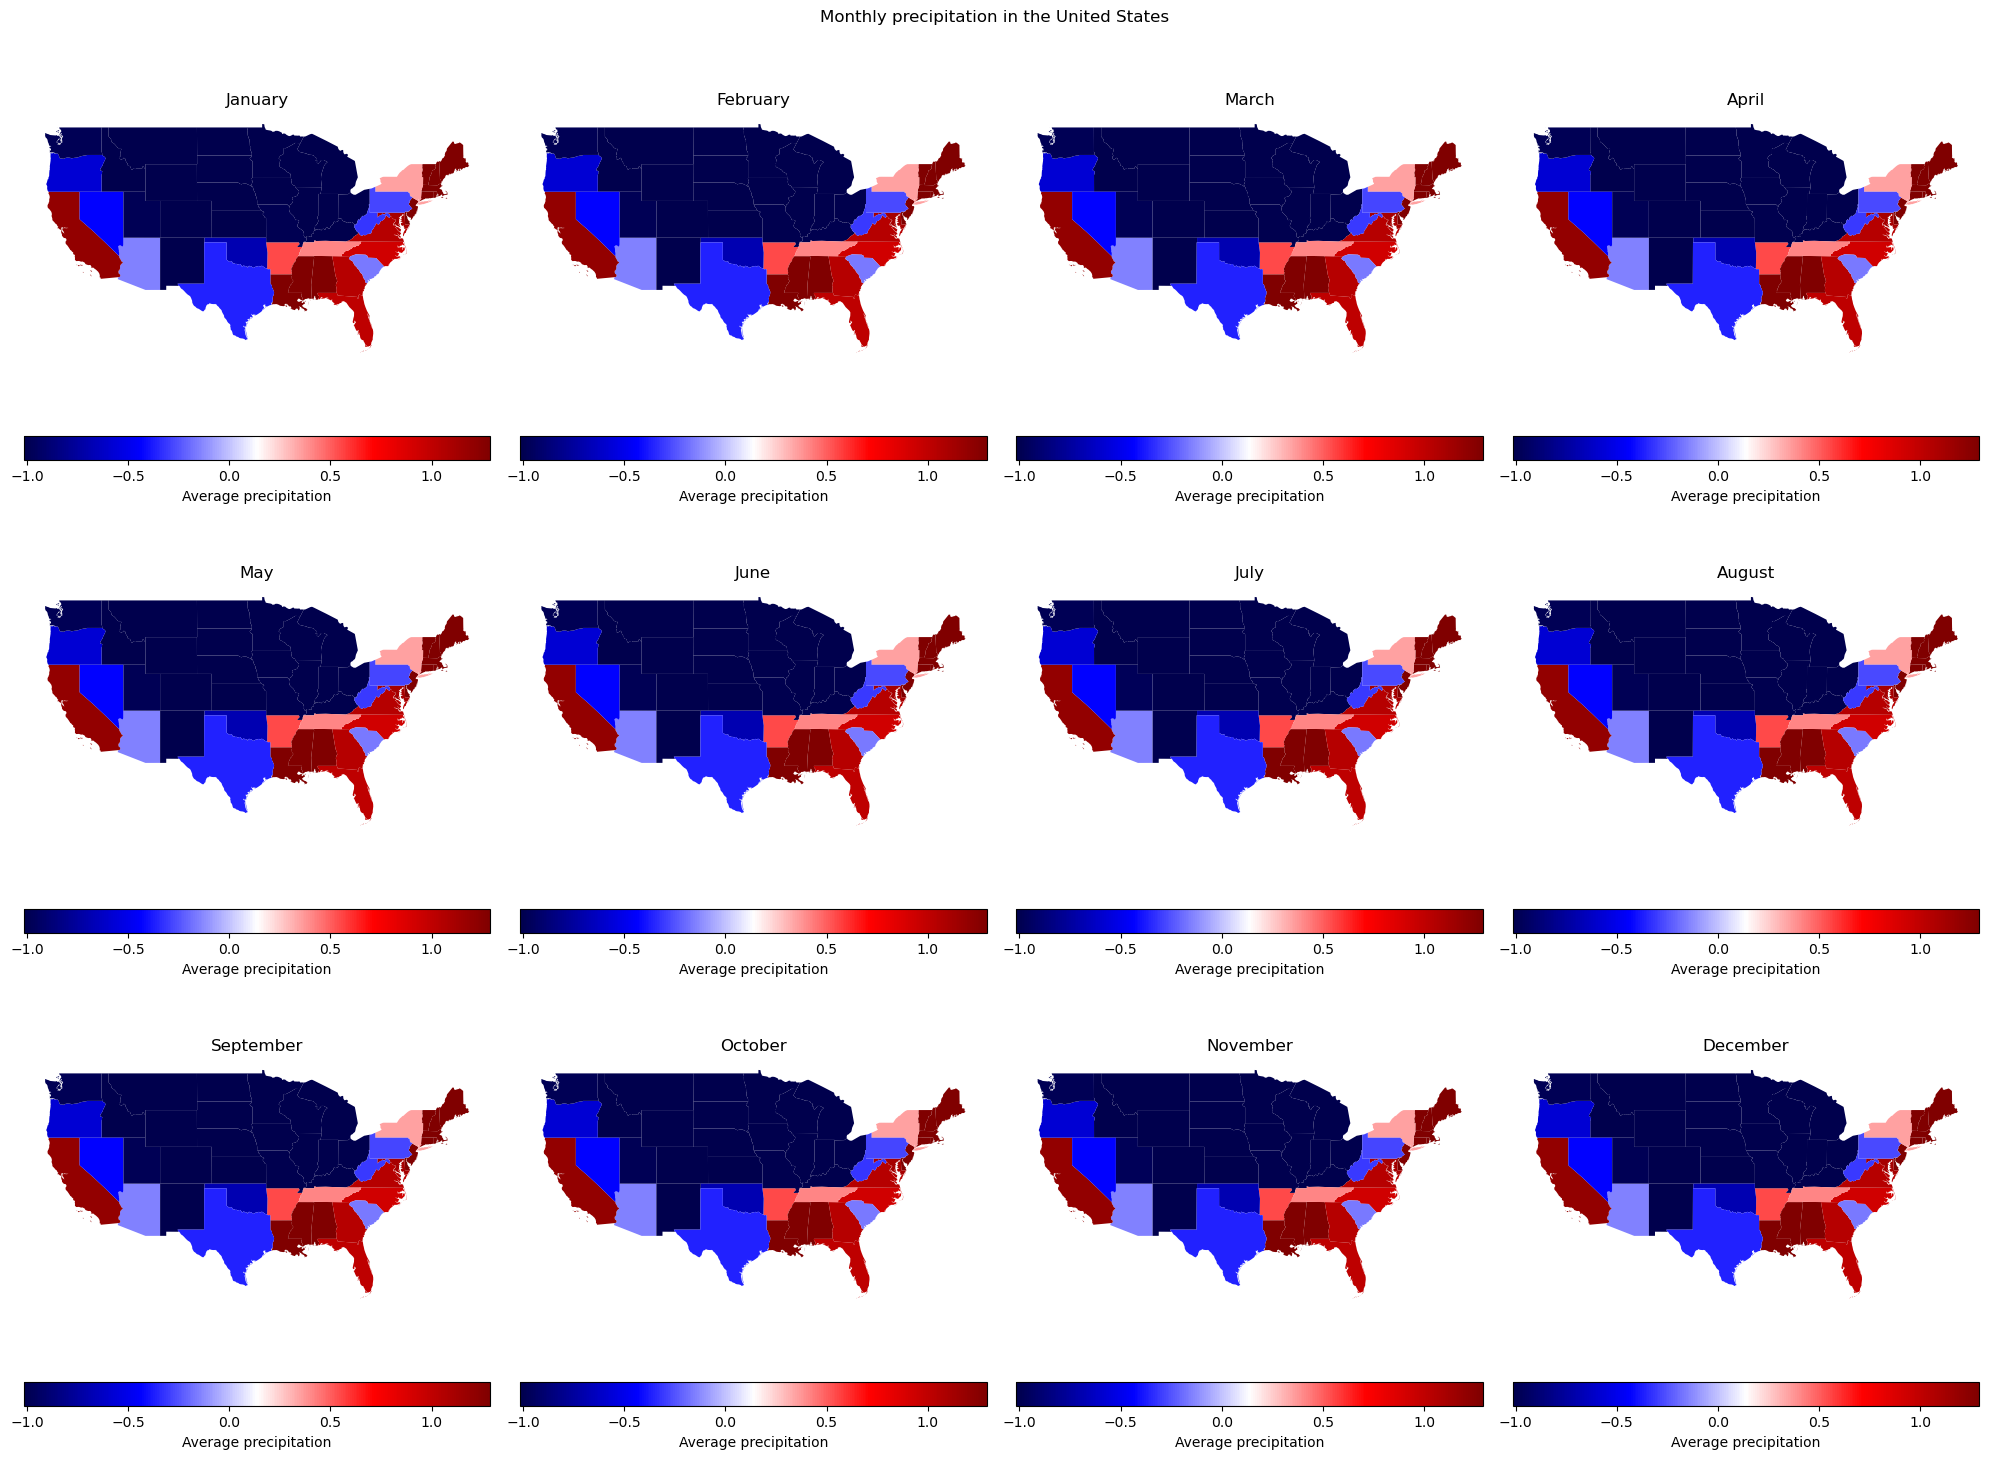

In [69]:

plot_usa(us_gdfs, 'prec')

# 4. Similarity of weather between Switzerland and USA states
## 4.1 Interpolate climatic data in Switzerland

In [ ]:
# Create vector of summary statistics for Switzerland
CH_monthly = np.zeros(24)
CH_monthly_st = np.zeros(24)

CH = world[world['ADMIN'] == 'Switzerland']

for i in range(12):

    mean_t = interpolate_temp(tmean_data[i], CH)
    mean_p = interpolate_temp(prec_data[i], CH)

    CH_monthly[i] = mean_t[0]
    CH_monthly[i + 12] = mean_p[0] 


[1.07182807e+01 9.12509174e+00 1.25107304e+01 1.47388980e+01
 1.65788645e+01 2.05446440e+01 2.50030916e+01 2.51209461e+01
 2.18420038e+01 2.07618160e+01 1.43962206e+01 1.20545574e+01
 4.94763668e+04 4.94757455e+04 4.94824402e+04 4.94696947e+04
 4.94677623e+04 4.94566035e+04 4.94559211e+04 4.94625949e+04
 4.94741398e+04 4.94651564e+04 4.95010884e+04 4.94679006e+04]


## 4.2 Append it to USA states data and normalize the whole data

In [83]:
_ = np.newaxis

us_comp = np.concatenate((t_stats, p_stats), axis=0)
comp_data = np.concatenate((CH_monthly[:,_], us_comp), axis=1)

av_tmean_comp = np.mean(comp_data[:12,:])
std_tmean_comp = np.std(comp_data[:12,:])
av_prec_comp = np.mean(comp_data[12:,:])
std_prec_comp = np.std(comp_data[12:,:])

comp_data_norm = np.zeros(comp_data.shape)
comp_data_norm[:12,:] = (comp_data[:12,:] - av_tmean_comp) / std_tmean_comp
comp_data_norm[12:,:] = (comp_data[12:,:] - av_prec_comp) / std_prec_comp

In [89]:
state_names = us['name']
print(state_names.values)

['Alabama' 'Arkansas' 'Arizona' 'California' 'Colorado' 'Connecticut'
 'District of Columbia' 'Delaware' 'Florida' 'Georgia' 'Iowa' 'Idaho'
 'Illinois' 'Indiana' 'Kansas' 'Kentucky' 'Louisiana' 'Massachusetts'
 'Maryland' 'Maine' 'Michigan' 'Minnesota' 'Missouri' 'Mississippi'
 'Montana' 'North Carolina' 'North Dakota' 'Nebraska' 'New Hampshire'
 'New Jersey' 'New Mexico' 'Nevada' 'New York' 'Ohio' 'Oklahoma' 'Oregon'
 'Pennsylvania' 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Virginia' 'Vermont' 'Washington' 'Wisconsin'
 'West Virginia' 'Wyoming']


In [195]:
state_names = us['name']
state_names = state_names.values

best_score = 100000
best_idx = 0
scores = []

for j in range(1, comp_data_norm.shape[1]-1):
    # Compute L2 norm difference
    diff_vector = comp_data_norm[:,0] - comp_data_norm[:,j]
    score = np.linalg.norm(diff_vector)
    scores.append(score)

    if score < best_score:
        best_score = score
        best_idx = j

results = zip(state_names, scores)
df_results = pd.DataFrame(results, columns=['state_name', 'score'])

df_results
df_sorted = df_results.sort_values(by='score')
df_sorted.iloc[:5,:]


,state_name,score
32,New York,1.713012
28,New Hampshire,2.054849
44,Vermont,2.105299
19,Maine,2.216390
18,Maryland,2.218121


# 5. Link with beer dataset

In [196]:
''' function.py '''
def generate_geodf(df, world):
    ''' Generate a GeoDataFrame with national information on beer preferences (average ratings, ...)
    and geometry information about the country, as to be able to generate world map of different beer-related
    variables.
    
    Input: 
        df: pd.DataFrame
            Cleaned dataset, including user_country
        world: gpd.GeoDataFrame
            Geometries of all countries, previously downloaded from naturalearth dataset
    
    Output:
        geo_df: gpd.GeoDataFrame
            National statistics on beer preferences and geometries of every country
        
    '''
    # Group by user_country and compute national statistics
    grouped_df = df.groupby(by="country_user").aggregate({'rating': 'mean', 'appearance': 'mean', 'aroma': 'mean', 
                                                      'palate': 'mean', 'taste': 'mean', 'overall': 'mean', 
                                                      'style': list, 'abv': 'count'})
    
    # Map differences in country names formatting to allow merging
    map = {
    'United States': 'United States of America',
    'Ivory Coast': 'United Republic of Tanzania',
    'Russia': 'Russian Federation',
    'United Kingdom': 'England',
    'Czech Republic': 'Czechia',
    'South Korea': 'Republic of Korea',
    'North Korea': 'Democratic People\'s Republic of Korea',
    'Syria': 'Syrian Arab Republic',
    'Laos': 'Lao People\'s Democratic Republic',
    'Palestine': 'State of Palestine',
    'Cape Verde': 'Cabo Verde',
    'Swaziland': 'Eswatini',
    'Micronesia': 'Federated States of Micronesia',
    'Vatican City': 'Holy See',
    'Macedonia': 'North Macedonia',
    'East Timor': 'Timor-Leste',
    'Moldova': 'Republic of Moldova',
    'Iran': 'Islamic Republic of Iran',
    'Tanzania': 'United Republic of Tanzania',
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Venezuela': 'Venezuela (Bolivarian Republic of)',
    'Brunei': 'Brunei Darussalam',
    'South Sudan': 'Republic of South Sudan',
    'Myanmar': 'Myanmar (Burma)',
    'Gambia': 'The Gambia',
    'Bahamas': 'The Bahamas',
    'Congo': 'Democratic Republic of the Congo',
    'Republic of the Congo': 'Congo',
    'Vietnam': 'Viet Nam',
    'Antigua': 'Antigua and Barbuda',
    'Trinidad': 'Trinidad and Tobago',
    'Saint Kitts': 'Saint Kitts and Nevis',
    'Saint Vincent': 'Saint Vincent and the Grenadines',
    'Saint Lucia': 'Saint Lucia',
    'Western Sahara': 'Sahrawi Arab Democratic Republic'
    }

    grouped_df = grouped_df.rename(index=map)

    # Left merge on world["ADMIN"] (country name)
    geo_df = world.merge(grouped_df, left_on="ADMIN", right_index=True, how="left")

    # computation of log(count) and replacing NAN values for visualization purposes
    geo_df['log_count'] = np.log(geo_df["abv"])
    geo_df.drop(columns="abv")
    geo_df.fillna(0, inplace=True)

    return geo_df

In [ ]:
def plot_geodf(geo_df):
    ''' Plot national beer preferences statistics on a world map
    
    Input:
        geo_df: gpd.GeoDataFrame
            Contains geometries of all countries and data about national beer preferences
            
    '''

    # geo_df = geo_df[geo_df["ADMIN"] != "Antarctica"]

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    geo_df.plot(column="log_count", ax=ax[0], legend=True, legend_kwds={'label': "Logarithmic count of reviews per country",
                            'location': 'bottom'})
    ax[0].set_title('Number of ratings per country')
    ax[0].axis('off')

    geo_df.plot(column="rating", ax=ax[1], legend=True, vmin=0.1, vmax=5, legend_kwds={'label': "Average rating per country",
                            'location': 'bottom'})
    ax[1].set_title('Average rating per country')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [198]:
df = pd.read_csv('../data/cleaned_ratings.csv')
geo_df = generate_geodf(df, world)

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_94888/3291615843.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/cleaned_ratings.csv')


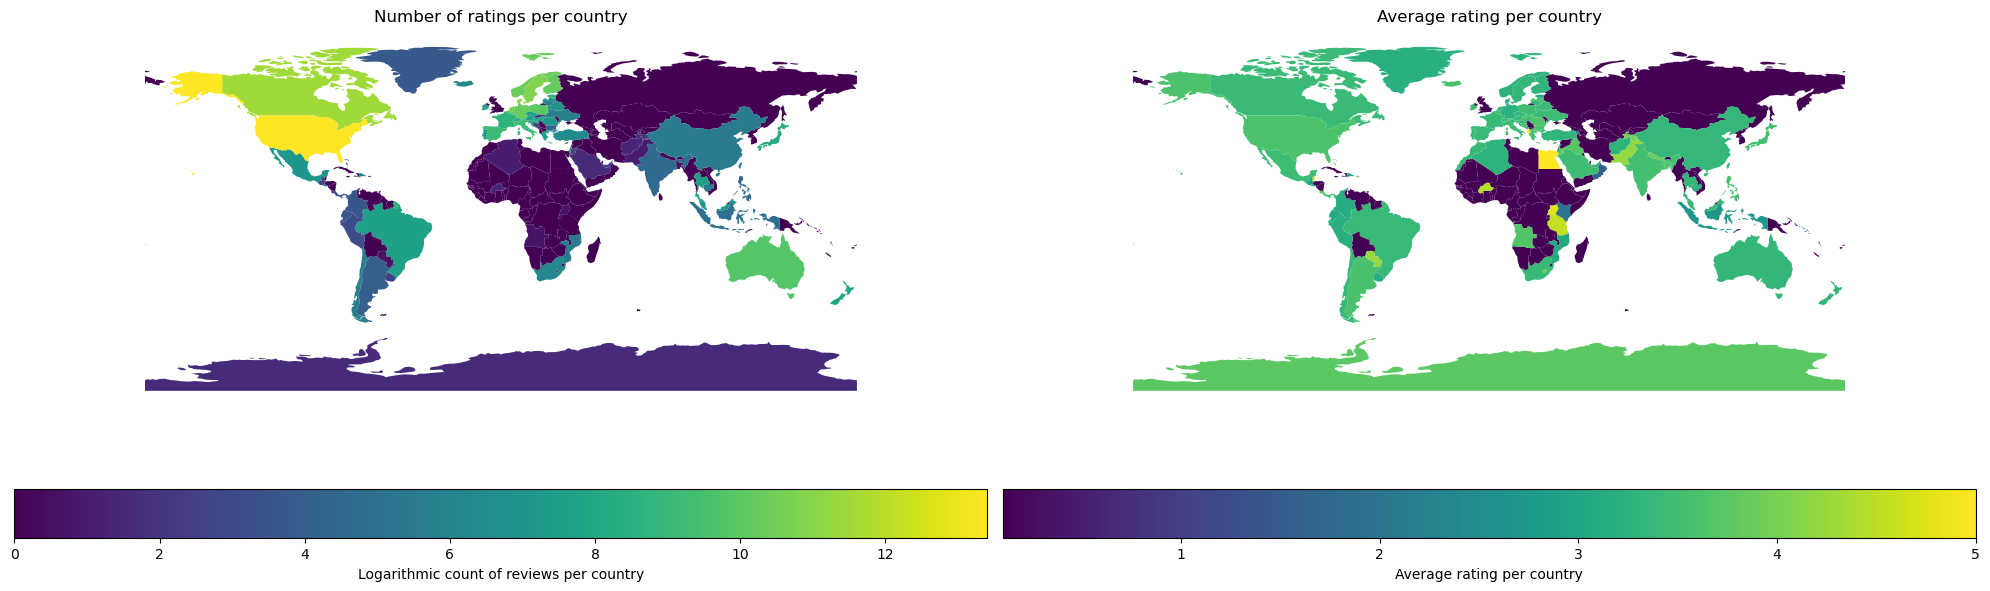

In [194]:
plot_geodf(geo_df)